In [3]:
import random
import time
import os
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from feature_engine.creation import CyclicalTransformer
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from catboost import CatBoostRegressor
from catboost import Pool
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

from sklearn.impute import KNNImputer

In [4]:
DATA_PATH = 'data/data_after_preprocessing.csv'  # path to the input data

END_DATE = '04/24/2022'                          # the last day we have the data for

DATA_CLUSTERS_PATH = 'data/clusters/'            # path to csv files generated by this notebook

# Full generated file name is NORMALIZED(STANDARD)_FILE_NAME_kmeans-{kmeans_cluster_id}_hier-{hierarchical_cluster_id}.csv
NORMALIZED_FILE_NAME = 'normalized_prepared'     # unified csv file name for weekly sales in normalized form
STANDARD_FILE_NAME = 'standard_prepared'         # unified csv file name for weekly sales in normalized form

# Check whether there is folder for clusters saving
if not os.path.exists(DATA_CLUSTERS_PATH):
    os.makedirs(DATA_CLUSTERS_PATH)

# Display all of the columns when data are shown
pd.set_option('display.max_columns', 60)

plt.rcParams['figure.figsize'] = (16, 8)
pd.options.mode.chained_assignment = None


# In some parts of this notebook there are references to "time run on laptop".
# Laptop specifications - OS: Ubuntu 21.04 LTS
#                         RAM: 16GB
#                         CPU: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
#                         GPU: GeForce GTX 1050 
# 

In [5]:
data =  pd.read_csv(DATA_PATH, sep=',', parse_dates=['doc_date', 'product_since'], low_memory=False)

In [6]:
data

,bill_country,currency_id,basket_id,doc_date,exchange_currency_rate,basket_total_price_with_vat,count_basket_items,basket_count_products,basket_type,item_quantity,item_type,item_unit_price_with_vat,item_total_discount_with_vat,product_id,category_id,brand_id,product_status,reviews_count,reviews_average_score_price,reviews_average_score_quality,reviews_average_score_properties,reviews_average_score_overall,reviews_average_score,is_in_stock,is_ended,is_new,is_boosted,product_purchase_price,eshop_stock_count,is_fifo,product_since,category_status,segment_id,default_warranty_period,doc_day,doc_month,doc_year,doc_weekday,doc_week,days_in_shop,ancestor_count,descendant_count,cluster_hierar,kmeans_cluster
0,1,1,1136409,2020-04-26,1.9558,345.00,18.0,18.0,1,1.0,1,5.34,0.28,39848,179.0,145,1,83.0,95.192308,93.653846,93.653846,94.423077,94.277108,1,0,0,0,2.2050,-2.0,0,2019-01-22,1,1.0,24.0,26,4,2020,6,17,1188,3,1.0,1,37
1,1,1,1571607,2020-08-07,1.9558,319.00,11.0,13.0,1,1.0,1,5.62,0.00,39848,179.0,145,1,83.0,95.192308,93.653846,93.653846,94.423077,94.277108,1,0,0,0,2.2050,-2.0,0,2019-01-22,1,1.0,24.0,7,8,2020,4,32,1188,3,1.0,1,37
2,1,1,1661756,2020-08-29,1.9558,180.95,2.0,2.0,1,1.0,1,5.62,0.00,39848,179.0,145,1,83.0,95.192308,93.653846,93.653846,94.423077,94.277108,1,0,0,0,2.2050,-2.0,0,2019-01-22,1,1.0,24.0,29,8,2020,5,35,1188,3,1.0,1,37
3,1,1,1701910,2020-09-09,1.9558,127.31,2.0,2.0,1,1.0,1,5.62,0.00,39848,179.0,145,1,83.0,95.192308,93.653846,93.653846,94.423077,94.277108,1,0,0,0,2.2050,-2.0,0,2019-01-22,1,1.0,24.0,9,9,2020,2,37,1188,3,1.0,1,37
4,1,1,262709,2019-06-06,1.9558,240.57,8.0,28.0,1,3.0,1,5.11,0.00,39848,179.0,145,1,83.0,95.192308,93.653846,93.653846,94.423077,94.277108,1,0,0,0,2.2050,-2.0,0,2019-01-22,1,1.0,24.0,6,6,2019,3,23,1188,3,1.0,1,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2713505,12,6,3375295,2021-08-16,1.0000,70.51,2.0,2.0,1,1.0,1,62.62,56.38,272147,2854.0,6755,1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1,1,0,0,29.7900,1.0,0,2021-05-04,1,6.0,24.0,16,8,2021,0,33,355,4,1.0,1,26
2713506,3,6,3057913,2022-02-03,1.0000,57.30,3.0,3.0,1,1.0,1,28.90,0.00,301637,1296.0,6481,1,1.0,0.000000,0.000000,0.000000,0.000000,100.000000,1,0,0,0,12.6300,1.0,0,2021-11-16,1,3.0,24.0,3,2,2022,3,5,159,2,1.0,3,68
2713507,9,6,3325485,2021-08-04,1.0000,329.00,1.0,1.0,3,1.0,1,329.00,0.00,274590,1304.0,6772,3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0,175.3200,0.0,0,2021-05-25,1,3.0,24.0,4,8,2021,2,31,334,2,1.0,3,26
2713508,11,9,1728853,2020-09-17,7.5415,260.96,14.0,14.0,1,1.0,1,16.84,0.00,191250,2042.0,2799,1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,0,0,10.9475,4.0,0,2019-12-06,1,16.0,24.0,17,9,2020,3,38,870,1,1.0,2,42


We want to make predictions weekly, as there are data with too little density for good daily prediction. Also we don't need to predict every single day, every week is fully enough.

In [7]:
days_together = data[['product_id', 'days_in_shop']].drop_duplicates().days_in_shop.sum()
all_sales_amount = len(data.index)
print(f'Non-zero values would be in {round(all_sales_amount / days_together, 5)*100}% of days')

Non-zero values would be in 2.34% of days


# Prepare data

## Drop unsettable columns
We want to predict, how many items of given type we will sell. That means - the predicted column will be 'item_quantity'. We don't know, how many items will be in basket, it's type etc. \
We only know values of columns we can influence (or which are already written) - for example price of the product, or it's brand. \
These columns were great for clustering products, as they can show some patterns in them, but for pure pretictions we are dropping those data.

In [8]:
data = data.drop(labels=['basket_id', 'basket_total_price_with_vat', 'basket_count_products', 'basket_type', 'count_basket_items', 'bill_country', 'currency_id', 'exchange_currency_rate', 'is_in_stock', 'eshop_stock_count'], axis=1)

After using Variance Threshold selection to find the columns with small variance we've found that LOW_VARIANCE_COLUMNS are viable for dropping as they are not good features for models. \
Code for finding such columns is provided and commented, but it is not desired to be a part of every program run, as this calculation takes some time. \
If use desires though, they can test the code, as written, on multiple clusters and find if the LOW_VARIANCE_COLUMNS list is still accurate. \
Those columns are dropped at this place though, so if such tests are desired it is necessary to remove the row 'data.drop(labels=LOW_VARIANCE_COLUMNS, axis=1)'.

In [9]:
## Drop columns that have too small variance to influence models 
# sel = VarianceThreshold(threshold=(0.16))
# sel.fit_transform(selected_cluster)
# to_drop = list(set(selected_cluster.columns) - set(sel.get_feature_names_out(selected_cluster.columns)))

LOW_VARIANCE_COLUMNS = ['descendant_count',
 'item_type',
 'is_ended',
 'is_fifo',
 'category_status',
 'is_new',
 'is_boosted']

data = data.drop(labels=LOW_VARIANCE_COLUMNS, axis=1)

In [10]:
def encode_values(df : pd.DataFrame) -> pd.DataFrame:
    """
    Transform columns by transformer suitable for them.
    Params
        df -> DataFrame containing columns for transformation
    Returns
        DataFrame -> DataFrame with values normalized by different techniques
    """

    # Cyclical transformation of date variables
    cyclical = CyclicalTransformer(variables=['week', 'month'], drop_original=True)
    df = cyclical.fit_transform(df)
    
    
    # Normalization for some variables is the best solution
    df['year'] = df['year'] / max(df['year'])

    
    # Use min max scaling for remaining columns
    scaler = MinMaxScaler()
    scaled_columns =['item_unit_price_with_vat', 'product_purchase_price', 'item_total_discount_with_vat', 'product_id', 'category_id', 'brand_id', 'segment_id', 'reviews_count',
                     'reviews_average_score_price', 'reviews_average_score_quality', 'reviews_average_score_properties', 'reviews_average_score_overall', 'reviews_average_score',
                     'product_status', 'ancestor_count', 'days_in_shop']
    
    for previous in range (1, PAST_WINDOW_SIZE + 1):
        scaled_columns.append(f'sold_{previous}_weeks_ago')
    
    
    scaled = scaler.fit_transform(df[scaled_columns])
    scaled = pd.DataFrame(scaled, columns = scaled_columns)
    
    for col in scaled_columns:
        df[col] = scaled[col].values
    
    return df

In [11]:
def missing_values_replace_knn(df : pd.DataFrame) -> pd.DataFrame:
        """
        Function for computing new values from dataframe using kNN. 
        Params
            df -> DataFrame of sales with NaN values as well.
        Returns 
            Original Dataframe with replaced NaNs.
        """
        
        knn = KNNImputer()
        knn_trans = knn.fit_transform(df)
        return pd.DataFrame(knn_trans, columns = df.columns)


In [12]:
PAST_WINDOW_SIZE = 4

def fill_zeroes_weekly(df: pd.DataFrame) -> pd.DataFrame: 
    """
    Function that takes DataFrame of sales and also fills weeks, where 0 products were sold. It also adds feature of last N weeks sold to DataFrame, as usefull features
    Params
        df -> DataFrame containing orders informations
    Returns
        DataFrame -> DataFrame containing weeks with 0 sales as well
    """
    date_columns = 'doc_date'
    desired_cols = ['year', 'week', 'month', 'quantity_sold', 'item_unit_price_with_vat',
       'product_purchase_price', 'item_total_discount_with_vat', 'product_id',
       'category_id', 'brand_id', 'segment_id', 'reviews_count',
       'reviews_average_score_price', 'reviews_average_score_quality',
       'reviews_average_score_properties', 'reviews_average_score_overall',
       'reviews_average_score', 'product_status',
        'ancestor_count',
       'days_in_shop']
    
    
    try:
        dates = pd.date_range(start=df.product_since.iloc[0], end=END_DATE)
        weekly_sales = dates.isocalendar()[['year', 'week']]
        weekly_sales['month'] = dates.month
        weekly_sales = weekly_sales.drop_duplicates()
    except:
        # If there is no sale of given product
        return pd.DataFrame(columns=desired_cols)

    
    sales, shop_days, item_price, item_discount, item_purchase_price = [], [], [], [], []
    for wk in weekly_sales.iterrows():
        if len(df[df.doc_week.__eq__(wk[1].week) & df.doc_month.__eq__(wk[1].month) & df.doc_year.__eq__(wk[1].year)].index) > 0:
            sales.append(df[df.doc_week.__eq__(wk[1].week) & df.doc_month.__eq__(wk[1].month) & df.doc_year.__eq__(wk[1].year)].item_quantity.sum())
            
            item_price.append(df[df.doc_week.__eq__(wk[1].week) & df.doc_month.__eq__(wk[1].month) & df.doc_year.__eq__(wk[1].year)].item_unit_price_with_vat.mean())
            item_purchase_price.append(df[df.doc_week.__eq__(wk[1].week) & df.doc_month.__eq__(wk[1].month) & df.doc_year.__eq__(wk[1].year)].product_purchase_price.mean())
            item_discount.append(df[df.doc_week.__eq__(wk[1].week) & df.doc_month.__eq__(wk[1].month) & df.doc_year.__eq__(wk[1].year)].item_total_discount_with_vat.mean())
            
        else:
            sales.append(0)
            item_price.append(None)
            item_purchase_price.append(None)
            item_discount.append(None)
        
        shop_days.append((wk[0] - df.product_since.iloc[0]).days)
    

    weekly_sales['quantity_sold'] = sales
    weekly_sales['item_unit_price_with_vat'] = item_price
    weekly_sales['product_purchase_price'] = item_purchase_price
    weekly_sales['item_total_discount_with_vat'] = item_discount
    weekly_sales[['product_id', 'category_id', 'brand_id', 'segment_id']] = df.product_id.iloc[0], int(df.category_id.iloc[0]), df.brand_id.iloc[0], df.segment_id.iloc[0]
    weekly_sales[['reviews_count', 'reviews_average_score_price', 'reviews_average_score_quality', 'reviews_average_score_properties', 'reviews_average_score_overall', 'reviews_average_score']] = \
    df.reviews_count.iloc[0], df.reviews_average_score_price.iloc[0], df.reviews_average_score_quality.iloc[0], df.reviews_average_score_properties.iloc[0], df.reviews_average_score_overall.iloc[0], df.reviews_average_score.iloc[0]
    weekly_sales[['product_status', 'ancestor_count']] = df.product_status.iloc[0], df.ancestor_count.iloc[0]
    weekly_sales['days_in_shop'] = shop_days
       
 
    try:
        weekly_sales = missing_values_replace_knn(weekly_sales)
    except:
        return pd.DataFrame(columns=desired_cols)
    
    
    for previous in range (1, PAST_WINDOW_SIZE + 1):
        past_values = weekly_sales['quantity_sold']
        weekly_sales[f'sold_{previous}_weeks_ago'] = past_values.shift(previous)

    
    weekly_sales
    return weekly_sales

In [13]:
def group_week(df : pd.DataFrame) -> pd.DataFrame:
    """
    We want to have data of product sales based on weekly sales, for that we need to squish our data into weekly ones.
    Params
        df -> DataFrame containing data of sales
    Return
        DataFrame -> DataFrame where sales are groupped by week sales rather than daily
    """
    
    df = df.drop(labels=['doc_weekday', 'doc_day'], axis=1)

    df = df.groupby(by=['product_id', 'doc_year', 'doc_month', 'doc_week'], as_index=False).agg({'item_quantity' : 'sum', \
                                                                                                   #  'item_type' : 'first', \
                                                                                                      'item_unit_price_with_vat' : 'mean', \
                                                                                                      'item_total_discount_with_vat' : 'mean', \
                                                                                                      'product_id' : 'first', \
                                                                                                      'category_id' : 'first', \
                                                                                                      'brand_id' : 'first', \
                                                                                                      'product_status' : 'first', \
                                                                                                      'reviews_count' : 'first', \
                                                                                                      'reviews_average_score_price' : 'first', \
                                                                                                      'reviews_average_score_quality' : 'first', \
                                                                                                      'reviews_average_score_properties' : 'first', \
                                                                                                      'reviews_average_score_overall' : 'first', \
                                                                                                      'reviews_average_score' : 'first', \
                                                                                                   #   'is_ended' : 'first', \
                                                                                                   #   'is_new' : 'first', \
                                                                                                   #   'is_boosted' : 'first', \
                                                                                                      'product_purchase_price' : 'mean', \
                                                                                                   #   'is_fifo' : 'first', \
                                                                                                   #   'category_status' : 'first', \
                                                                                                      'segment_id' : 'first', \
                                                                                                      'default_warranty_period' : 'first', \
                                                                                                      'days_in_shop' : 'first', \
                                                                                                      'ancestor_count' : 'first', \
                                                                                                   #   'descendant_count' : 'first', \
                                                                                                      'product_since' : 'first'                  
                                                                                                      }) 

    
    weekly_sales = pd.DataFrame()
    for prod in df.product_id.unique():
        weekly_sales = pd.concat([weekly_sales, fill_zeroes_weekly(df[df.product_id.__eq__(prod)])])

    weekly_sales = weekly_sales.apply(pd.to_numeric)
    
    return weekly_sales

In [14]:
def prepare_cluster_data(df: pd.DataFrame, hierarchical_cluster : id, kmeans_cluster : id, normalized : bool =True) -> pd.DataFrame:
    """
    Function that cleanse, prepares and returns data of weekly sales in given cluster.
    Params
        df - dataframe containing required data
        hierarchical cluster - hierarchical cluster number, usually from <1, 3> interval
        kmeans cluster - cluster decicded by kmeans clustering, usually from <1, 101> interval
        normalized - default True. True returns normalized data in columns other than quantity_sold
    Returns
        pd.DataFrame - DataFrame containing weekly sales of each product in the cluster
    """
    
    # Check if required file is not generated already. If it is, return according csv file 
    check_existence = DATA_CLUSTERS_PATH+STANDARD_FILE_NAME+'_kmeans-'+str(kmeans_cluster)+'_hier-'+str(hierarchical_cluster)+'.csv'
    if normalized:
        check_existence = DATA_CLUSTERS_PATH+NORMALIZED_FILE_NAME+'_kmeans-'+str(kmeans_cluster)+'_hier-'+str(hierarchical_cluster)+'.csv'    
        
    if os.path.exists(check_existence):     
        return pd.read_csv(check_existence, sep=',', low_memory=False)
    
    
    selected_cluster = data[data.cluster_hierar.__eq__(hierarchical_cluster) & data.kmeans_cluster.__eq__(kmeans_cluster)]
    
    # Drop clusters as they are the same for each product of given cluster
    selected_cluster = selected_cluster.drop(labels=['cluster_hierar', 'kmeans_cluster'], axis=1)
    
    
    # Next we need to rework data to weekkly sales rather than daily 
    selected_cluster = group_week(selected_cluster)
    
    if normalized:
        selected_cluster = encode_values(selected_cluster)
        
    return selected_cluster

In [15]:
def test_train_yearly_split(df : pd.DataFrame, normalized_year : bool =True, y_column : str='quantity_sold') -> tuple:
    """
    Function splitting dataframe to train test and X, y parts based on year and quantity_sold parameters.
    Params
        df - pd.DataFrame containing desired columns for split
        normalized_year - default True. Determine if the column 'year' is normalized or not. Needs this information for proper data split.
        y_column - default quantity_sold. Column used as the y part of dataset
    Returns
        tuple - tuple containing prepared (normalized) and split data in order (X_train, y_train, X_test, y_test) - 
    """
    split_at_year = 2022
    
    if normalized_year: 
        split_at_year /= int(END_DATE[-4:])
    
    y_train = df[df.year < split_at_year][[y_column]]
    y_test = df[df.year >= split_at_year][[y_column]]

    X_train = df[df.year < split_at_year].drop(labels=[y_column], axis=1)
    X_test = df[df.year >= split_at_year].drop(labels=[y_column], axis=1)
    
    return(X_train.fillna(0), y_train, X_test, y_test)

In [16]:
def prepare_weekly_csvs(df : pd.DataFrame, normalized :bool = True):
    """
    Function to generate csv files of weekly sales in advance, so those weekly sales don't have to be calculated every time the program is run, but are rather only loaded from .csv files.
    This approach is trading memory (approximately 6GBs of files for one type (normalized VS standard)) - generally speaking, it is fully enough to generate all normalized files, there
    is no need to generate standard ones. The tradeoff is saving computing power and speeding up the program for future runs.
    
    Approximate runtime on laptop: 8 hours.
    Params 
        df - DataFrame containing orders information to sum weekly
        normalized - default True. If to save normalized or full data
    """
    start = time.time()

    for kmns in range(101):
        print(f'Working on kmeans cluster number {kmns}')
        for hier in range(1, 4):
            # path of the new file contaning normalized data prepared for the split
            file_path = DATA_CLUSTERS_PATH+STANDARD_FILE_NAME+'_kmeans-'+str(kmns)+'_hier-'+str(hier)+'.csv'
            if normalized:
                file_path = DATA_CLUSTERS_PATH+NORMALIZED_FILE_NAME+'_kmeans-'+str(kmns)+'_hier-'+str(hier)+'.csv'
        
        
            if not os.path.exists(file_path):
                prepare_cluster_data(df, hier, kmns, normalized).to_csv(file_path, index=False)
            else:
                print(f'File already exists!: {file_path}')

    end = time.time()
    print(f"{(end-start)/60} minutes.")

In [15]:
prepare_weekly_csvs(data, True)

Working on kmeans cluster number 0
File already exists!: data/clusters/normalized_prepared_kmeans-0_hier-1.csv
File already exists!: data/clusters/normalized_prepared_kmeans-0_hier-2.csv
File already exists!: data/clusters/normalized_prepared_kmeans-0_hier-3.csv
Working on kmeans cluster number 1
File already exists!: data/clusters/normalized_prepared_kmeans-1_hier-1.csv
File already exists!: data/clusters/normalized_prepared_kmeans-1_hier-2.csv
File already exists!: data/clusters/normalized_prepared_kmeans-1_hier-3.csv
Working on kmeans cluster number 2
File already exists!: data/clusters/normalized_prepared_kmeans-2_hier-1.csv
File already exists!: data/clusters/normalized_prepared_kmeans-2_hier-2.csv
File already exists!: data/clusters/normalized_prepared_kmeans-2_hier-3.csv
Working on kmeans cluster number 3
File already exists!: data/clusters/normalized_prepared_kmeans-3_hier-1.csv
File already exists!: data/clusters/normalized_prepared_kmeans-3_hier-2.csv
File already exists!: da

In [17]:
def feature_importance_xgb(df : pd.DataFrame, TEST_SIZE : int = 10, model : XGBRegressor = None) -> dict:
    """
    Let's check the importance of remaining features based on TEST_SIZE random cluster predictions.
    Params
        df - DataFrame containing information about product sales.
        TEST_SIZE - Default 10, how many random models should be tested to find out the values importance.
        model - XGB Regressor model to test on. If None, then there is predefined model used in the function.
    Returns
        dictionary - containing all feature names and their importances - averaged from the entire TEST_SIZE of trees.
    """
    tested = [[]]
    xgb_feature_importance = []
    
    for check in range (TEST_SIZE):
        
        test_cluster = []
        while test_cluster in tested:
            test_cluster = [random.randint(1, 100), random.randint(1, 3)] 
        
        tested.append(test_cluster)
        
        X_train, y_train, X_test, y_test = test_train_yearly_split(prepare_cluster_data(df, test_cluster[1], test_cluster[0]))
        
        while(len(y_test) == 0):
            test_cluster = [random.randint(1, 100), random.randint(1, 3)] 
            X_train, y_train, X_test, y_test = test_train_yearly_split(prepare_cluster_data(df, test_cluster[1], test_cluster[0]))
            tested.append(test_cluster)

        if model is None:
            model = XGBRegressor(learning_rate = 0.05, n_estimators=250,
                           max_depth=4, min_child_weight=1,
                           gamma=0, subsample=0.8, reg_lambda=10,       
                           early_metric='auc',
                           eval_set=[(X_test, y_test)],
                           colsample_bytree=0.8, objective= "reg:squarederror",  
                           nthread=-1,scale_pos_weight=1, seed=27,
                          importance_type='total_gain')
        
        
        model.fit(X_train, y_train)

        if check == 0:
            xgb_feature_importance = xgb.feature_importances_
        else:
            xgb_feature_importance += xgb.feature_importances_
            
        print(f'Done {check+1} out of {TEST_SIZE} models. ({round((1+check)*100/TEST_SIZE, 2)}%)')
    
    names, values = (xgb.get_booster().feature_names, xgb_feature_importance / TEST_SIZE)
    return[{name: value} for (name, value) in zip(names, values)]

In [18]:
def hyperparameter_tuning(X_train_data : pd.DataFrame, X_test_data : pd.DataFrame, y_train_data : pd.DataFrame, \
                          y_test_data : pd.DataFrame , model, param_grid : dict, cv : int =10, scoring_fit  : str ='neg_mean_squared_error', n_iterations : int = 10):
    """
    Function using RandomizedSearch to tune hyperparameters to find very good fitting parameters in a reasonable time. Can be swapped for GridSearchCV, but that is way slower.
    Params
        X_train_data, X_test_data, y_train_data, y_test_data - DataFrames containing splitted train and test data.
        model - MachineLearning model to be tested.
        param_grid - Grid of parameters with their runing values..
        scoring_fit - string according to scroring options of RandomizedSearachCV. Default is neg_MAE.
        n_iterations - amount of models to test in the RandomizedSearch.
    Returns
        fitted_model - best model found
        pred - prediction made on the test dataset
    """
    rs = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grid, 
            cv=cv, 
            n_jobs=1, 
            n_iter=n_iterations,
            scoring=scoring_fit,
            verbose=5
        )
    fitted_model = rs.fit(X_train_data, y_train_data)

    return fitted_model

In [19]:
def evaluate_model(real_numbers : list, predicted_numbers : list) -> dict:
    """
    Method which uses various metrics to evaluate predictions compared to the real numbers.
    More info about following techniques of evaluation available in the documentation: https://scikit-learn.org/stable/modules/model_evaluation.html
    Params
        real_numbers - list/np.array/Series containing true values to compare against 
        predicted_numbers - list/np.array/Series containing predicted values which we want to evaluate
    Returns 
        dict - dictinoary containing scores of different evaluation methods
    """
    round_size = 4
    
    ### 3 main metrics used to evaluate regressions. Lower values are better. They all compute average error size, in different ways
    medae = round(median_absolute_error(real_numbers, predicted_numbers), round_size)
    mae = round(mean_absolute_error(real_numbers, predicted_numbers), round_size)
    mse = round(mean_squared_error(real_numbers, predicted_numbers), round_size)
    
    # The F1 score can be interpreted as a harmonic mean of the precision and recall. The best value is 1.0.
    f1 = round(f1_score(real_numbers, predicted_numbers.round(), average='weighted', zero_division=1), round_size)
    
    ### 3 more metrics used to evaluate models. They all have the best values at 1
    accuracy = round(accuracy_score(real_numbers, predicted_numbers.round()), round_size)
    recall = round(recall_score(real_numbers, predicted_numbers.round(), average='weighted', zero_division=1), round_size)
    precision = round(precision_score(real_numbers, predicted_numbers.round(), average='weighted', zero_division=1), round_size)
    
    # Regression metrics are important for regressions, so we want to have their average as score of options 
    # In other words how well the regression model did in average based on regression metrics only
    regress = round((mae + medae + mse) / 3, round_size)
    
    # Calculate total score of the model - find the average distance of metrics from the ideal score
    total = medae + mae + mse + (1 - f1) + (1 - accuracy) + (1 - recall) + (1 - precision)
    total /= 7
    total = round(total, round_size)
    
    return {'medae' : medae, 'mae' : mae, 'mse' : mse , 'f1' : f1, 'accuracy' : accuracy, 'recall' : recall, 'precision' : precision, 'regress' : regress, 'total' : total}

In [20]:
def run_evaluate_model(df : pd.DataFrame, model, hier : int, kmeans : int, tune_hyperparameters : bool = False, parameters_to_tune : dict = {}) -> dict:
    """
    Function that prepares desired cluster data, runs inserted model on them and evaluates the outcome.
    Params
        df - DataFrame containing sales information
        hier - hierarchical cluster ID
        kmeans - kmeans cluster ID
        model - Regression model to test
        tune_hyperparameters - default False. If True, use RandomSearchCV on given cluster to find hyperparameters. If True, requires parameters_train as well.
        parameters_to_tune - default {}. Dictionary of parameters to tune on given model.
        
    Returns
        dict - dictionary containing evaluation values of model over data.
    """
    
    # Select data and make split
    selected_cluster = prepare_cluster_data(df, hier, kmeans, normalized=True)
    X_train, y_train, X_test, y_test = test_train_yearly_split(selected_cluster)
    y_train = y_train.quantity_sold.values
    y_test = y_test.quantity_sold.values
    
    if tune_hyperparameters:
        # Tune hyperparameters with the usage of RandomSearch
        model, _ = hyperparameter_tuning(X_train, X_test, y_train, y_test, xgb_r, parameters_to_tune, cv=2, n_iterations=50)
    
    model.fit(X_train, y_train)
    
    predicted_train = model.predict(X_train)
    predicted_test = model.predict(X_test)
    
    train_evaluated = evaluate_model(y_train, predicted_train)
    test_evaluated = evaluate_model(y_test, predicted_test)
    
    return {f'kmeans-{kmeans}_hierarchical-{hier}' : {'train' : train_evaluated, 'test' : test_evaluated}}

# XGBoost regressor

In [21]:
# Set up training parameters for XGBoost
parameters_XGB = { 
    'booster' : ['gbtree', 'gblinear'], 
    'eta' : [0.01, 0.05, 0.1, 0.2, 0.3, 0.6, 1],   # learning rate
    'n_estimators': [250, 400, 700, 1000],
    'colsample_bytree': [0.4, 0.6, 0.8, 1.0],
    'max_depth': [3, 5, 7, 10, 15],
    'reg_alpha': [0, 0.5 , 1, 1.1, 1.3],
    'reg_lambda': [0.5, 1, 1.1, 1.3],
    'subsample': [0.4, 0.6, 0.7, 0.8],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'objective': ['reg:squarederror', 'reg:squaredlogerror'],
}

In [24]:
start = time.time()

# Select random cluster and tune hyperparameters on it
# Alternative would be to tune hyperparameters for every single model, but that would be very time consuming
selected_cluster = prepare_cluster_data(data, 1, 1, True)
X_train, y_train, X_test, y_test = test_train_yearly_split(selected_cluster)



xgb_r = XGBRegressor(
        seed=29,
        verbosity=0)
model = hyperparameter_tuning(X_train, X_test, y_train, y_test, xgb_r, parameters_XGB, cv=5, n_iterations=50)

end = time.time()
print(f"{(end-start)/60} minutes.")
best_params_xgb = model.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END booster=gblinear, colsample_bytree=0.6, eta=0.3, gamma=2, max_depth=5, min_child_weight=1, n_estimators=1000, objective=reg:squaredlogerror, reg_alpha=1.1, reg_lambda=1.1, subsample=0.4;, score=-0.180 total time=   7.4s
[CV 2/5] END booster=gblinear, colsample_bytree=0.6, eta=0.3, gamma=2, max_depth=5, min_child_weight=1, n_estimators=1000, objective=reg:squaredlogerror, reg_alpha=1.1, reg_lambda=1.1, subsample=0.4;, score=-0.244 total time=   6.7s
[CV 3/5] END booster=gblinear, colsample_bytree=0.6, eta=0.3, gamma=2, max_depth=5, min_child_weight=1, n_estimators=1000, objective=reg:squaredlogerror, reg_alpha=1.1, reg_lambda=1.1, subsample=0.4;, score=-0.125 total time=   7.5s
[CV 4/5] END booster=gblinear, colsample_bytree=0.6, eta=0.3, gamma=2, max_depth=5, min_child_weight=1, n_estimators=1000, objective=reg:squaredlogerror, reg_alpha=1.1, reg_lambda=1.1, subsample=0.4;, score=-0.121 total time=   6.9s
[CV 5/

In [25]:
xgb = XGBRegressor(verbosity=0, 
                   subsample=best_params_xgb['subsample'],
                   seed=29,
                   reg_lambda=best_params_xgb['reg_lambda'],
                   reg_alpha=best_params_xgb['reg_alpha'],
                   objective=best_params_xgb['objective'],
                   n_estimators=best_params_xgb['n_estimators'],
                   min_child_weight=best_params_xgb['min_child_weight'],
                   max_depth=best_params_xgb['max_depth'],
                   gamma=best_params_xgb['gamma'],
                   eta=best_params_xgb['eta'],
                   colsample_bytree=best_params_xgb['colsample_bytree'],
                   booster=best_params_xgb['booster'])

In [26]:
xgb

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.4, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None, gamma=5,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:squaredlogerror',
             predictor=None, random_state=None, ...)

In [152]:
evaluated_clusters_xgb = {}

for kmns in range(101):
    if kmns % 10 == 0:
        print(kmns)
    for hier in range(1, 4):
        try:
            key, = run_evaluate_model(data, xgb, hier, kmns, False).items()
            evaluated_clusters_xgb[key[0]] = key[1]
        except:
            # Some of the clusters only contain last year of sales, so we can skip those
            pass

0
10
20
30
40
50
60
70
80
90
100


In [153]:
with open('xgb_evaluated.json', 'w') as outfile:
    json.dump(evaluated_clusters_xgb, outfile)

# CatBoostRegressor

In [32]:
params_CB = {'max_depth' : [5,8,10],
              'learning_rate' : [0.01, 0.02, 0.05, 0.1],
              'iterations'    : [50, 100, 250, 500],
              'l2_leaf_reg'   : [5, 10, 20]
              }

In [33]:
start = time.time()

cbr = CatBoostRegressor(
    loss_function='RMSE',
    random_seed=29,
    od_type='Iter',
    od_wait=25,
    verbose=0,
    )

model = hyperparameter_tuning(X_train, X_test, y_train, y_test, cbr, params_CB, cv=5, n_iterations=50)

end = time.time()
print(f"{(end-start)/60} minutes.")
best_params_cbr = model.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END iterations=50, l2_leaf_reg=5, learning_rate=0.01, max_depth=10;, score=-0.176 total time=   2.9s
[CV 2/5] END iterations=50, l2_leaf_reg=5, learning_rate=0.01, max_depth=10;, score=-0.230 total time=   1.0s
[CV 3/5] END iterations=50, l2_leaf_reg=5, learning_rate=0.01, max_depth=10;, score=-0.117 total time=   1.1s
[CV 4/5] END iterations=50, l2_leaf_reg=5, learning_rate=0.01, max_depth=10;, score=-0.118 total time=   1.1s
[CV 5/5] END iterations=50, l2_leaf_reg=5, learning_rate=0.01, max_depth=10;, score=-0.198 total time=   1.1s
[CV 1/5] END iterations=50, l2_leaf_reg=5, learning_rate=0.05, max_depth=8;, score=-0.177 total time=   0.6s
[CV 2/5] END iterations=50, l2_leaf_reg=5, learning_rate=0.05, max_depth=8;, score=-0.218 total time=   0.7s
[CV 3/5] END iterations=50, l2_leaf_reg=5, learning_rate=0.05, max_depth=8;, score=-0.110 total time=   0.6s
[CV 4/5] END iterations=50, l2_leaf_reg=5, learning_rate=0.05

In [34]:
cbr = CatBoostRegressor(
    loss_function='RMSE',
    random_seed=29,
    od_type='Iter',
    od_wait=25,
    verbose=0,
    max_depth=best_params_cbr['max_depth'],
    learning_rate=best_params_cbr['learning_rate'],
    iterations=best_params_cbr['iterations'],
    l2_leaf_reg=best_params_cbr['l2_leaf_reg']
    )

In [154]:
evaluated_clusters_cbr = {}

for kmns in range(101):
    if kmns % 10 == 0:
        print(kmns)
    for hier in range(1, 4):
        try:
            key, = run_evaluate_model(data, cbr, hier, kmns, False).items()
            evaluated_clusters_cbr[key[0]] = key[1]
        except:
            # Some of the clusters only contain last year of sales, so we can skip those
            pass

0
10
20
30
40
50
60
70
80
90
100


In [155]:
with open('cbr_evaluated.json', 'w') as outfile:
    json.dump(evaluated_clusters_cbr, outfile)

# AdaBoostRegressor

In [38]:
params_ADA = {'n_estimators':[50,100,500,1000, 1500],
              'learning_rate':[.001,0.01,.1, .5, 1],
              'loss':['square', 'linear'],
              }

In [39]:
start = time.time()

ada = AdaBoostRegressor(random_state=0, n_estimators=100)

rs = GridSearchCV(
            estimator=ada,
            param_grid=params_ADA, 
            cv=2, 
            n_jobs=1, 
            scoring='neg_mean_squared_error',
            verbose=5
        )
model = rs.fit(X_train, y_train.quantity_sold.values)

end = time.time()
print(f"{(end-start)/60} minutes.")
best_params_ada = model.best_params_

Fitting 2 folds for each of 50 candidates, totalling 100 fits
[CV 1/2] END learning_rate=0.001, loss=square, n_estimators=50;, score=-0.212 total time=   1.9s
[CV 2/2] END learning_rate=0.001, loss=square, n_estimators=50;, score=-0.151 total time=   1.9s
[CV 1/2] END learning_rate=0.001, loss=square, n_estimators=100;, score=-0.212 total time=   3.8s
[CV 2/2] END learning_rate=0.001, loss=square, n_estimators=100;, score=-0.153 total time=   4.0s
[CV 1/2] END learning_rate=0.001, loss=square, n_estimators=500;, score=-0.214 total time=  19.6s
[CV 2/2] END learning_rate=0.001, loss=square, n_estimators=500;, score=-0.155 total time=  20.0s
[CV 1/2] END learning_rate=0.001, loss=square, n_estimators=1000;, score=-0.216 total time=  39.0s
[CV 2/2] END learning_rate=0.001, loss=square, n_estimators=1000;, score=-0.163 total time=  40.3s
[CV 1/2] END learning_rate=0.001, loss=square, n_estimators=1500;, score=-0.218 total time=  59.5s
[CV 2/2] END learning_rate=0.001, loss=square, n_estima

In [41]:
best_params_ada

{'learning_rate': 0.001, 'loss': 'linear', 'n_estimators': 100}

In [156]:
ada = AdaBoostRegressor(
    random_state=0,
    n_estimators=best_params_ada['n_estimators'],
    learning_rate=best_params_ada['learning_rate'],
    loss=best_params_ada['loss'])

In [157]:
evaluated_clusters_ada = {}

for kmns in range(101):
    if kmns % 10 == 0:
        print(kmns)
    for hier in range(1, 4):
        try:
            key, = run_evaluate_model(data, ada, hier, kmns, False).items()
            evaluated_clusters_ada[key[0]] = key[1]
        except:
            # Some of the clusters only contain last year of sales, so we can skip those
            pass

0
10
20
30
40
50
60
70
80
90
100


In [159]:
with open('ada_evaluated.json', 'w') as outfile:
    json.dump(evaluated_clusters_ada, outfile)

# Evaluations

After fitting the data onto all models and evaluating their success rates, the time comes to look at how successful we have been. \
The MEDAE and MAE metrics are valued the most, as they are fullfilling the needs of evaluating the regression the best. \
If user wishes, they can just go straight to evaluate the models, as the results are saved in the json output files.

In [133]:
with open('ada_evaluated.json') as json_file:
    evaluated_clusters_ada = json.load(json_file)
    
with open('xgb_evaluated.json') as json_file:
    evaluated_clusters_xgb = json.load(json_file)
    
with open('cbr_evaluated.json') as json_file:
    evaluated_clusters_cbr = json.load(json_file)

In [136]:
def get_score_json(json_file : json, metrics : str, from_train : bool = False) -> list:
    """
    Function for selecting one value only from json files stored alongisde this code.
    Parameters
        json_file - loaded json file in Python.
        metrics - string containing one of the metrics types to be selected.
        from_train - default False. If True, select given value based on train split predictions.
    Returns
        list - list containing values from given split and metric
    """
    data_part = 'test'
    
    if from_train:
        data_part = 'train'
        
    returnable_metrics = []
    for kmns in range(1, 101):
        for hier in range(1, 4):
            try:
                returnable_metrics.append(json_file[f'kmeans-{kmns}_hierarchical-{hier}'][data_part][metrics])
            except:
                pass
    
    
    return returnable_metrics

In [160]:
models_evaluated = {  'ada' : evaluated_clusters_ada,
                      'xgb' : evaluated_clusters_xgb,
                      'cbr' : evaluated_clusters_cbr}

In [161]:

for metric in ['total', 'mae', 'medae']:
    print(f'Mean values of the {metric}')
    
    for key  in models_evaluated:
        print(key, '->', round(np.mean(get_score_json(models_evaluated[key], metric)), 4))
        
    print(f'Median values of the {metric}')    
    for key  in models_evaluated:
        print(key, '->', round(np.median(get_score_json(models_evaluated[key], metric)), 4))

Mean values of the total
ada -> 0.1593
xgb -> 0.1314
cbr -> 0.1501
Median values of the total
ada -> 0.12
xgb -> 0.1011
cbr -> 0.1216
Mean values of the mae
ada -> 0.2149
xgb -> 0.1497
cbr -> 0.2053
Median values of the mae
ada -> 0.189
xgb -> 0.1362
cbr -> 0.1862
Mean values of the medae
ada -> 0.0864
xgb -> 0.0282
cbr -> 0.0827
Median values of the medae
ada -> 0.0758
xgb -> 0.0253
cbr -> 0.0741


In [61]:
predicted = xgb.predict(X_train)
predicted_test = xgb.predict(X_test)

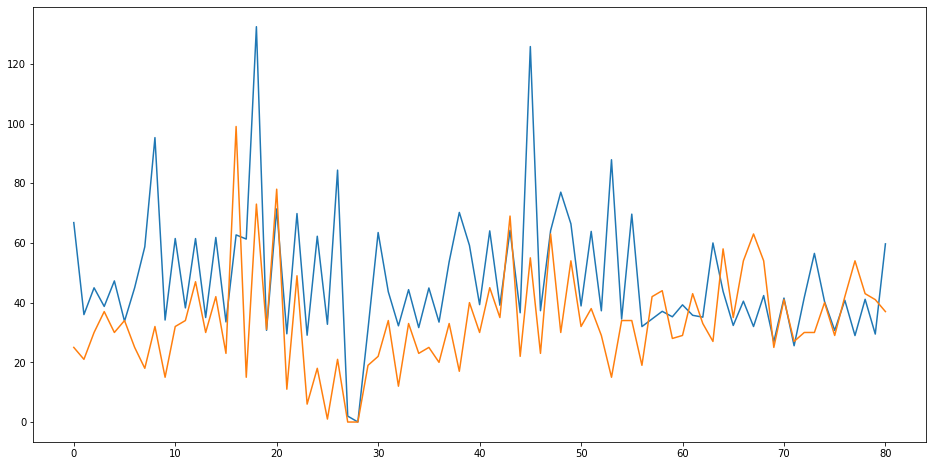

In [62]:
plt.plot(pd.DataFrame({'year' : X_train.year, 'week_sin' : X_train.week_sin, 'week_cos' : X_train.week_cos, 'sales' : predicted}).groupby(by=['year', 'week_sin', 'week_cos'], as_index=False).sum().dropna().sales)
plt.plot(pd.DataFrame({'year' : X_train.year, 'week_sin' : X_train.week_sin, 'week_cos' : X_train.week_cos, 'sales' : y_train.quantity_sold}).groupby(by=['year', 'week_sin', 'week_cos'], as_index=False).sum().dropna().sales)

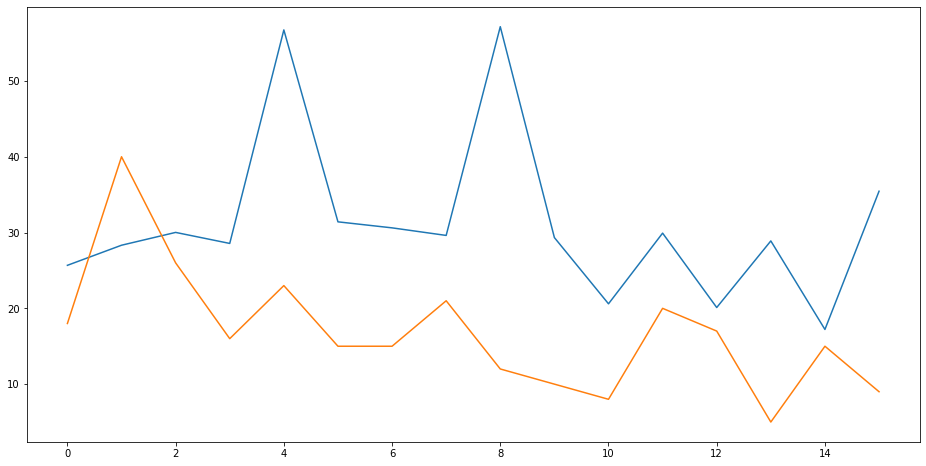

In [63]:
plt.plot(pd.DataFrame({'year' : X_test.year, 'week_sin' : X_test.week_sin, 'week_cos' : X_test.week_cos, 'sales' : predicted_test}).groupby(by=['year', 'week_sin', 'week_cos'], as_index=False).sum().dropna().sales)
plt.plot(pd.DataFrame({'year' : X_test.year, 'week_sin' : X_test.week_sin, 'week_cos' : X_test.week_cos, 'sales' : y_test.quantity_sold}).groupby(by=['year', 'week_sin', 'week_cos'], as_index=False).sum().dropna().sales)